### TP Détecteur de parole V1.0 ###
Scherrer Arthur, Mahouin Julien, Alexis Noliere, Nicolas Tachet



## Importation des librairies

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io.wavfile as sio
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
import math
from scipy.stats import multivariate_normal

## Importation du fichier audio
On importe le fichier audio avec la librairie scipy.io.wavfile. On récupère le taux d'échantillonnage et le signal audio ainsi que ça durée.

In [135]:
sample,test = sio.read('test_2.wav')
print("Nombre d'échantillon par seconde", sample)
print("Nombre d'échantillon total",len(test))

# On cherche le temps en seconde du fichier audio
temps_seconde = len(test)/sample
print("Le temps du fichiers audio en seconde est de : ",temps_seconde)


Nombre d'échantillon par seconde 16000
Nombre d'échantillon total 57489603
Le temps du fichiers audio en seconde est de :  3593.1001875


On divise le signal audio par des fenêtre de 30ms avec un pas de 10 ms. 

In [136]:
#On divise le signal en fenêtre de 30ms
fenetre = 30
fenetre_echantillon = int(fenetre*sample/1000)
print("Le nombre d'échantillon par fenêtre est de : ",fenetre_echantillon)

#On en déduit le nombre de fenêtre
nb_fenetre = int(len(test)/fenetre_echantillon)
print("Le nombre de fenêtre est de : ",nb_fenetre)

Le nombre d'échantillon par fenêtre est de :  480
Le nombre de fenêtre est de :  119770


La matrice est de dimension :  (119770, 480)
L'énergie totale de la matrice est de :  [18.3501931  19.75342678 18.57448836 ... 18.56318498 18.94371868
 18.6764075 ]


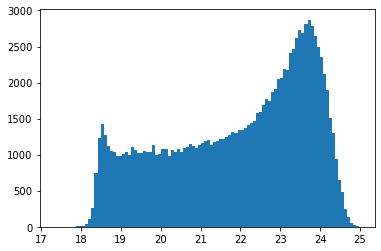

In [137]:
#On convertie le tableau en matrice avec strid avec 160 colonnes
matrice = np.lib.stride_tricks.as_strided(test, shape=(nb_fenetre, fenetre_echantillon), strides=(test.strides[0]*fenetre_echantillon, test.strides[0]))
print("La matrice est de dimension : ",matrice.shape)

#Calcul de l'énergie totale de la matrice
energie_test = np.sum(np.array(matrice, dtype='int64')**2,axis=1)
#Si l'energie est égale a 0 on le remplace par 1
#energie_test[energie_test==0]=1
energie = np.log((energie_test))
print("L'énergie totale de la matrice est de : ",energie)

#historgramme de l'énergie
plt.hist(energie, bins=100)
plt.show()


### Question 3

À combien d’échantillons correspondent respectivement 30 et 10 ms ?

10 ms = 160, 30 ms = 480

# Étape 2 - Apprendre un GMM

In [138]:
# Distribution 1
x1 = np.random.normal(0, 1, 1000)
y1 = np.random.normal(0, 1, 1000)

# Distribution 2
x2 = np.random.normal(5, 1, 1000)
y2 = np.random.normal(5, 1, 1000)

# Création du modèle par concaténation
X = np.concatenate((np.vstack((x1, y1)).T, np.vstack((x2, y2)).T), axis=0)

print(X)

[[-0.23075543 -0.34132134]
 [ 1.17388757 -0.73093387]
 [ 0.63369718  2.11788653]
 ...
 [ 3.62529278  4.07227749]
 [ 4.59704104  4.62131567]
 [ 6.00177766  5.83225818]]


Création de l'objet GMM

In [139]:
gmm = GaussianMixture(n_components = 3, verbose = 10, max_iter = 10)
gmm.fit(X)

Initialization 0
Initialization converged: True	 time lapse 0.02014s	 ll -3.54657


GaussianMixture(max_iter=10, n_components=3, verbose=10)

Classe des nouvelles données

In [140]:
new_data = np.array([[0, 0], [5, 5]])
labels = gmm.predict(new_data)
print(labels)

[1 0]


Visualisation des résultats

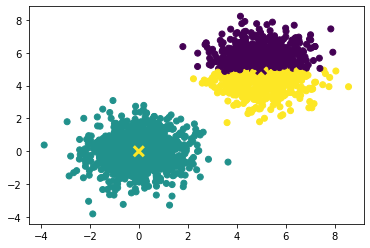

In [141]:
plt.scatter(X[:, 0], X[:, 1], c=gmm.predict(X))
plt.scatter(new_data[:, 0], new_data[:, 1], c=labels, marker='x', s=100, linewidths=3)
plt.show()

### Question 5
quelle sera la dimension des gaussiennes ?
-> univariées
### Question 6
quelle est la méthode d'initialisation du modèle ?
-> np.concatenate() ?
### Question 7
À quoi correspondent les valeurs "change" dans la sortie de l'apprentissage ?
-> Changement de gaussienne
### Question 8
est-il important de fixer à diag ou full la forme des matrices de covariances ?
-> Oui, car si on fixe à diag, on considère que les variables sont indépendantes, ce qui n'est pas le cas ici.
### Question 9
quelle est la vraisemblance du modèle sur les données d'apprentissage ?


Initialization 0
Initialization converged: True	 time lapse 0.17746s	 ll -1.82209
Gaussienne 1 :
  Poids : 0.296
  Moyenne : 21.642
  Covariance : 0.580
Gaussienne 2 :
  Poids : 0.254
  Moyenne : 19.434
  Covariance : 0.501
Gaussienne 3 :
  Poids : 0.451
  Moyenne : 23.514
  Covariance : 0.306


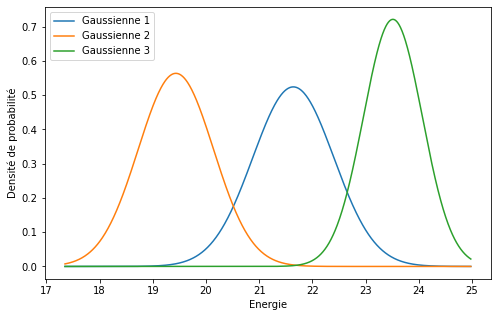

In [142]:
# Créer une instance de GMM avec 3 composantes, covariance complète et verbose à 10
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=10, verbose=10)

# Transformer le corpus d'énergies en un vecteur colonne
X = energie.reshape(-1, 1)

# Entraîner le modèle sur le corpus d'énergies
gmm.fit(X)

# Récupérer les paramètres des gaussiennes
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

# Afficher les paramètres de chaque gaussienne
for i in range(len(weights)):
    print(f"Gaussienne {i+1} :")
    print(f"  Poids : {weights[i]:.3f}")
    print(f"  Moyenne : {means[i][0]:.3f}")
    print(f"  Covariance : {covariances[i][0][0]:.3f}")

# Définir l'intervalle de valeurs pour lesquelles tracer les courbes
x = np.linspace(X.min(), X.max(), 1000)

# Tracer les courbes des gaussiennes
plt.figure(figsize=(8, 5))
for i in range(len(weights)):
    y = multivariate_normal.pdf(x, mean=means[i], cov=covariances[i])
    plt.plot(x, y, label=f"Gaussienne {i+1}")
plt.xlabel("Energie")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.show()

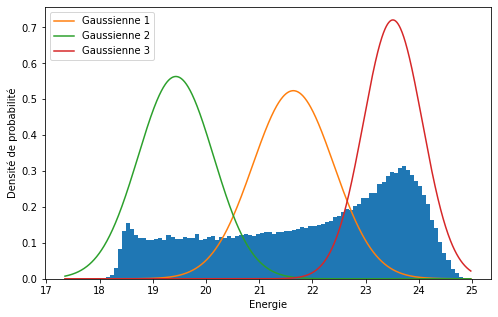

In [143]:
# On fussione l'histogramme et les courbes des gaussiennes
plt.figure(figsize=(8, 5))
plt.hist(X, bins=100, density=True)
for i in range(len(weights)):
    y = multivariate_normal.pdf(x, mean=means[i], cov=covariances[i])
    plt.plot(x, y, label=f"Gaussienne {i+1}")
plt.xlabel("Energie")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.show()

In [144]:
#Calcul de la médiane des gaussiennes
mediane = np.median(means)
print("La médiane des gaussiennes est de : ",mediane)

#Calcul de l'écart type
ecart_type = np.std(means)
print("L'écart type des gaussiennes est de : ",ecart_type)

silence = mediane - 2*ecart_type
print("Le seuil de silence est de : ",silence)


La médiane des gaussiennes est de :  21.64208553789114
L'écart type des gaussiennes est de :  1.6674024434008907
Le seuil de silence est de :  18.30728065108936


In [145]:
silence = energie[energie < silence]
print("Le nombre de fenêtre de silence est de : ",len(silence))

#On effectue l'exponentielle sur le tableau de silence
silence = np.log(silence)

#On effectue la racine carré sur le tableau de silence
silence = np.sqrt(silence)


print(silence)

sio.write("silence.wav", sample, silence)


Le nombre de fenêtre de silence est de :  298
[1.70371669 1.7047625  1.70474243 1.70474163 1.70322396 1.70473967
 1.70432709 1.70448336 1.70394033 1.70506882 1.70495161 1.70398335
 1.7044748  1.70488127 1.70171898 1.70396209 1.70503271 1.70393264
 1.70439993 1.70228892 1.70309197 1.7027034  1.7035027  1.70408899
 1.70017691 1.70424943 1.70230863 1.70252441 1.70417053 1.70133197
 1.7049567  1.70494597 1.70264613 1.69439786 1.70466534 1.70400051
 1.7045336  1.70451665 1.70405894 1.69737545 1.70484173 1.6998313
 1.70350841 1.70390805 1.69864602 1.70112724 1.70500099 1.70324132
 1.70441387 1.70420669 1.70478653 1.70278879 1.69933228 1.70197611
 1.70356198 1.70340503 1.70215445 1.70407301 1.70423023 1.70120567
 1.70493294 1.69971419 1.70480431 1.70429164 1.70368145 1.70497614
 1.70471147 1.70232683 1.70429661 1.70405648 1.70264333 1.70150285
 1.70415951 1.70424814 1.69499525 1.70441089 1.7013809  1.70330274
 1.70458982 1.70124018 1.69901871 1.7042957  1.70433861 1.70417089
 1.70088516 1.702

### Etape 4 - Algorithme EM

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io.wavfile as wav
from sklearn.mixture import GaussianMixture
import wave

In [49]:
#On veux générer un détecteur de silence, pour cela on va utiliser un modèle de mélange de gaussienne



In [146]:
# Charger un fichier audio et convertir en échantillons
fs, audio = wav.read('test_2.wav')
audio = audio / (2.0**15)

# Paramètres pour découper le signal audio en fenêtres de 30 ms avec un pas de 10 ms
window_size = 30
step_size = int(fenetre*sample/1000)

# Découper le signal audio en fenêtres
signal_windows = []
for i in range(0, len(audio) - window_size, step_size):
    window = audio[i:i + window_size]
    signal_windows.append(window)

# Convertir les fenêtres audio en vecteurs de caractéristiques
features = np.abs(np.fft.fft(signal_windows))
features = features[:, :int(features.shape[1]/2)]

# Entraîner un modèle GMM à 3 composantes
gmm = GaussianMixture(n_components=3, covariance_type='diag')
gmm.fit(features)

# Trouver la probabilité de chaque fenêtre audio d'appartenir au cluster 3 (le cluster le plus éloigné)
cluster_probs = gmm.predict_proba(features)
silence_probs = cluster_probs[:, 2]

# Décider si chaque fenêtre audio est du silence ou non en utilisant un seuil de probabilité
threshold = 0.8
is_silence = silence_probs > threshold

# Fusionner les fenêtres audio contenant du silence
silence_windows = []
for i in range(len(is_silence)):
    if is_silence[i]:
        window = audio[i*step_size:i*step_size + window_size]
        silence_windows.append(window)

#On regarde si il y a du recouvrement entre les fenêtres de silence
for i in range(len(silence_windows)):
    if i != 0:
        if silence_windows[i][0] == silence_windows[i-1][-1]:
            print("Il y a du recouvrement entre les fenêtres de silence")

#On enlève le revouvrement entre les fenêtres de silence
for i in range(len(silence_windows)):
    if i != 0:
        if silence_windows[i][0] == silence_windows[i-1][-1]:
            silence_windows[i] = silence_windows[i][1:]
            
# Concaténer les fenêtres audio contenant du silence pour obtenir le signal de silence final
silence = np.concatenate(silence_windows)
print(silence)

# On génére un fichier audio de silence
sio.write("silence.wav", sample, silence)

Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
Il y a du recouvrement entre les fenêtres de silence
[-0.05090332 -0.04351807 -0.03262329 ...  0.00622559  0.01489258
  0.01983643]


In [34]:
# Charger un fichier audio et convertir en échantillons
fs, audio = wav.read('test_2.wav')
audio = audio / (2.0**15)

# Paramètres pour découper le signal audio en fenêtres de 30 ms avec un pas de 10 ms
window_size = 30
step_size = int(fenetre*sample/1000)

# Définir les paramètres de seuillage
threshold_start = 0.05
threshold_end = 0.01
alpha = 1.1
beta = 0.9
gamma = 0.9

# Initialiser les paramètres
threshold = threshold_start
silence_duration = 0
is_silence = np.zeros(len(audio), dtype=bool)

# Parcourir chaque fenêtre audio
for i in range(0, len(audio) - window_size, step_size):
    # Calculer la puissance du signal dans la fenêtre courante
    power = np.sum(audio[i:i+window_size]**2) / window_size
    
    # Si la puissance est inférieure au seuil actuel, augmenter la durée de silence
    if power < threshold:
        silence_duration += step_size
    # Sinon, mettre à jour le seuil et réinitialiser la durée de silence
    else:
        threshold = alpha * threshold + beta * power
        silence_duration = gamma * silence_duration
        
    # Si la durée de silence est supérieure à 100 ms, marquer les échantillons correspondants comme étant du silence
    if silence_duration > 0.1 * fs:
        is_silence[i:i+window_size] = True

# Fusionner les fenêtres audio contenant du silence
silence_windows = []
for i in range(len(is_silence)):
    if is_silence[i]:
        window = audio[i*step_size:i*step_size + window_size]
        silence_windows.append(window)

# Concaténer les fenêtres audio contenant du silence pour obtenir le signal de silence final
silence = np.concatenate(silence_windows)
print(silence)

#On cherche a enlever le recouvrement entre les fenêtres de silence
silence = silence[0::fenetre_echantillon]

# On génére un fichier audio de silence
sio.write("silence.wav", fs, silence)


[-0.00900269  0.02127075  0.00073242 ... -0.13632202 -0.13595581
 -0.13418579]


In [ ]:
e: /Users/tachet/Documents/GitHub/Weather/Weather/app/src/main/java/master/kotlin/weather/MainActivity.kt: (26, 30): Unresolved reference: databinding